# EDA

- [Introducción a la competición](#Titanic---Machine-Learning-from-Disaster)
- [Descripción del dataset](#Descripción-del-dataset)
- [Importar librerías](#Importar-librerías)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#Exploratory-Data-Analysis)
    - [Hipótesis previas](#Hipótesis-previas)
    - [Exploración](#Exporación-del-dataset)
    - [Análisis univariable](#Análisis-Univariable)
        - [Estadísticas descriptivas](#Estadísticas-descriptivas) 
        - [Visualizaciones](#Visualizaciones)
    - [Análisis multivariable](#Análisis-Multivariable)
    - [Testeo de hipótesis](#Testeo-Hipótesis)
- [Conclusiones](#Conclusiones)

## Titanic - Machine Learning from Disaster
El hundimiento del Titanic es uno de los naufragios más infames de la historia.

El 15 de abril de 1912, durante su viaje inaugural, el ampliamente considerado "insumergible" RMS Titanic se hundió tras chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de los 2224 pasajeros y tripulantes.

Si bien hubo un elemento de suerte en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

En este desafío, te pedimos que construyas un modelo predictivo que responda a la pregunta: "¿qué tipo de personas tenían más probabilidades de sobrevivir?" utilizando los datos de los pasajeros (es decir, nombre, edad, género, clase socioeconómica, etc.).

[Enlace a la competición en kaggle](https://www.kaggle.com/competitions/titanic)

## Descripción del dataset

Los datos se han dividido en dos grupos:

- Conjunto de entrenamiento (train.csv)
- Conjunto de prueba (test.csv)

El **conjunto de entrenamiento** debe utilizarse para construir tus modelos de machine learning. Para el conjunto de entrenamiento, proporcionamos el resultado (también conocido como "ground truth") para cada pasajero. Tu modelo se basará en "características" como el género y la clase de los pasajeros. También puedes usar ingeniería de características para crear nuevas variables.

El **conjunto de prueba** debe utilizarse para evaluar qué tan bien se desempeña tu modelo con datos no vistos. Para el conjunto de prueba, no proporcionamos la verdad real para cada pasajero. Es tu tarea predecir estos resultados. Para cada pasajero en el conjunto de prueba, utiliza el modelo que entrenaste para predecir si sobrevivió o no al hundimiento del Titanic.

### Diccionario de Datos

| **Variable** | **Definición**                                  | **Clave**                                      |
|:------------:|:-----------------------------------------------:|:----------------------------------------------:|
| survival     | Supervivencia                                   | `0 = No, 1 = Sí`                               |
| pclass       | Clase del boleto                                | `1 = 1ra, 2 = 2da, 3 = 3ra`                    |
| sex          | Sexo                                            |                                                |
| age          | Edad en años                                    |                                                |
| sibsp        | Número de hermanos/cónyuges a bordo del Titanic |                                                |
| parch        | Número de padres/hijos a bordo del Titanic      |                                                |
| ticket       | Número de boleto                                |                                                |
| fare         | Tarifa del pasajero                             |                                                |
| cabin        | Número de cabina                                |                                                |
| embarked     | Puerto de embarque                              | `C = Cherburgo, Q = Queenstown, S = Southampton` |


### Notas sobre las Variables

- **pclass**: Un indicador del estatus socioeconómico (SES)

    - 1ra = Upper

    - 2da = Middle

    - 3ra = Lower
      
- **age**: La edad es fraccionada si es menor a 1. Si la edad es estimada, aparece en la forma xx.5
  
- **sibsp**: El conjunto de datos define las relaciones familiares de esta manera...
  
    - Sibling = brother, sister, stepbrother, stepsister
  
    - Spouse = husband, wife (se ignoraron amantes y prometidos)
  
- **parch**: El conjunto de datos define las relaciones familiares de esta manera...
  
    - Parent = mother, father

    - Child = daughter, son, stepdaughter, stepson

Algunos niños viajaban solo con una niñera, por lo tanto, parch=0 para ellos.

## Importar librerías

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

## Lectura de datos

In [2]:
INPUT_ZIP = "./00_Data/Raw/titanic.zip"  # Directorio del zip
OUTPUT_FOLDER = "./00_Data/Raw"  # Directorio de destino
TRAIN_FILENAME = "train.csv"  # Nombre del fichero de entrenamiento

def fetch_data(input_path=INPUT_ZIP, output_dir=OUTPUT_FOLDER):
    """
    Extrae el contenido de un archivo ZIP en un directorio de destino.

    Parámetros:
    -----------
    input_path : str, opcional
        Ruta al archivo ZIP que se desea descomprimir. El valor predeterminado es la variable 'INPUT_ZIP'.
        
    output_dir : str, opcional
        Directorio en el cual se extraerá el contenido del archivo ZIP. Si el directorio no existe,
        será creado automáticamente. El valor predeterminado es la variable 'OUTPUT_FOLDER'.

    Comportamiento:
    ---------------
    - Crea el directorio de destino si no existe.
    - Descomprime el archivo ZIP en el directorio de destino.

    Excepciones:
    ------------
    Puede lanzar una excepción si el archivo ZIP no existe o si hay problemas al descomprimirlo.

    Ejemplo de uso:
    ---------------
    fetch_data('data.zip', 'output/')
    """
    # Comprobación de que el directorio de destino existe
    os.makedirs(output_dir, exist_ok=True)

    # Descomprime el archivo ZIP en caso de que no haya ningún csv en la carpeta
    if(len([file for file in os.listdir(output_dir) if file.endswith('.csv')]) == 0):
        with zipfile.ZipFile(input_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)


def load_data(directory=OUTPUT_FOLDER, filename=TRAIN_FILENAME):
    """
    Lee un archivo CSV desde el directorio especificado.

    Parámetros:
    -----------
    directory : str
        El directorio donde se encuentra el archivo CSV.
        
    filename : str
        El nombre del archivo CSV a leer (incluyendo la extensión .csv).

    Retorna:
    --------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del archivo CSV.

    Excepciones:
    ------------
    FileNotFoundError:
        Se lanza si el archivo no existe en el directorio dado.
    
    Ejemplo de uso:
    ---------------
    df = read_csv_from_directory('data', 'file.csv')
    """
    # Construir la ruta completa al archivo CSV
    file_path = os.path.join(directory, filename)

    # Verificar si el archivo existe
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo {filename} no se encuentra en el directorio {directory}")

    # Leer el archivo CSV en un DataFrame
    return pd.read_csv(file_path)

fetch_data()
df = load_data()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Hipótesis previas

1. **Hipótesis de Género**: Las mujeres tuvieron una mayor probabilidad de sobrevivir que los hombres debido al protocolo de evacuación de "mujeres y niños primero".

2. **Hipótesis de Clase**: Los pasajeros de clases más altas (`Pclass = 1`) tuvieron una mayor probabilidad de sobrevivir en comparación con los pasajeros de clases más bajas, reflejando las desigualdades sociales de la época.

3. **Hipótesis de Edad**: Los pasajeros más jóvenes (niños) tuvieron una mayor probabilidad de sobrevivir debido a que se les dio prioridad en los esfuerzos de rescate.

4. **Hipótesis de Tamaño de la Familia**: Los pasajeros que viajaban con familia tuvieron mayores probabilidades de sobrevivir en comparación con aquellos que viajaban solos. Sin embargo, familias muy grandes pudieron tener dificultades para escapar juntas, reduciendo sus posibilidades de supervivencia.

5. **Hipótesis de la Tarifa**: Los pasajeros que pagaron tarifas más altas tuvieron una mayor probabilidad de sobrevivir, ya que es probable que estuvieran en camarotes de clases superiores y tuvieran mejor acceso a los botes salvavidas.

6. **Hipótesis del Punto de Embarque**: Los pasajeros que embarcaron en ciertos puntos, como Cherburgo (`Embarked = C`), tuvieron mayores probabilidades de sobrevivir debido a diferencias en riqueza o ubicación de los camarotes.

7. **Hipótesis de Disponibilidad de Cabina**: Los pasajeros con información de cabina disponible (`Cabin` no nulo) tuvieron una mayor probabilidad de sobrevivir, ya que probablemente estaban en las secciones de clase alta del barco.

8. **Hipótesis de Título**: Los pasajeros con ciertos títulos, como `Mrs`, `Miss` o `Master` (niños), tuvieron mejores probabilidades de sobrevivir que otros, reflejando su estatus social o edad.

9. **Hipótesis del Número de Ticket**: Los pasajeros con números de ticket similares, lo que podría indicar que viajaban juntos, tuvieron probabilidades de supervivencia correlacionadas.

10. **Hipótesis de Interacciones**:
    - **Género y Clase**: Las mujeres de clases más altas tuvieron la mayor tasa de supervivencia.
    - **Edad y Clase**: Los niños de clases más bajas tuvieron menos probabilidades de sobrevivir que los niños de clases más altas.
    - **Tamaño de Familia y Tarifa**: Los pasajeros con familias más pequeñas y tarifas más altas tuvieron mayores probabilidades de supervivencia.

## Exploratory Data Analysis

### Exporación del dataset

In [3]:
df.shape

(891, 12)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Comentarios:
- Existen missing values en 'Age', 'Cabin' y 'Embarked' con los que tendremos que tratar.
- Los tipos de las variables parecen correctos, aunque 'Age' debería ser entero y aparece como float --> posiblemente por los NaNs
- La columna 'Name' no aporta mucho por sí misma, veremos si podemos extraer algo de ésta que sí valga.

### Análisis Univariable

#### Estadísticas descriptivas

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [9]:
# Calcular moda
df.mode().T

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
PassengerId,1,2,3,4,5,6,7,8,9,10,...,882,883,884,885,886,887,888,889,890,891
Survived,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pclass,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,"Abbing, Mr. Anthony","Abbott, Mr. Rossmore Edward","Abbott, Mrs. Stanton (Rosa Hunt)","Abelson, Mr. Samuel","Abelson, Mrs. Samuel (Hannah Wizosky)","Adahl, Mr. Mauritz Nils Martin","Adams, Mr. John","Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Aks, Mrs. Sam (Leah Rosen)","Albimona, Mr. Nassef Cassem",...,"Yrois, Miss. Henriette (""Mrs Harbeck"")","Zabour, Miss. Hileni","Zabour, Miss. Thamine","Zimmerman, Mr. Leo","de Messemaeker, Mrs. Guillaume Joseph (Emma)","de Mulder, Mr. Theodore","de Pelsmaeker, Mr. Alfons","del Carlo, Mr. Sebastiano","van Billiard, Mr. Austin Blyler","van Melkebeke, Mr. Philemon"
Sex,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SibSp,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ticket,1601,347082,CA. 2343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,8.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Calcular moda (elimino 'Name' & 'PassengerID' para eliminar múltiples columnas)
df.drop(columns=["Name", "PassengerId"]).mode().T

,0,1,2
Survived,0.0,NaN,NaN
Pclass,3.0,NaN,NaN
Sex,male,NaN,NaN
Age,24.0,NaN,NaN
SibSp,0.0,NaN,NaN
Parch,0.0,NaN,NaN
Ticket,1601,347082,CA. 2343
Fare,8.05,NaN,NaN
Cabin,B96 B98,C23 C25 C27,G6
Embarked,S,NaN,NaN


In [11]:
# Calcular IQR
df.describe().T["75%"] - df.describe().T["25%"]

PassengerId    445.0000
Survived         1.0000
Pclass           1.0000
Age             17.8750
SibSp            1.0000
Parch            0.0000
Fare            23.0896
dtype: float64

In [12]:
# Calcular rango
df.describe().T["max"] - df.describe().T["min"]

PassengerId    890.0000
Survived         1.0000
Pclass           2.0000
Age             79.5800
SibSp            8.0000
Parch            6.0000
Fare           512.3292
dtype: float64

In [13]:
# Almacenar columnas numéricas para evitar error
num_columns = df.describe().columns
num_columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [14]:
# Calcular asimetría
"""
valor > 0 -> distribución asimétrica a la derecha
valor = 0 -> distribución simétrica
valor < 0 -> distribución asimétrica a la izquierda
"""
df[num_columns].skew()

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

In [15]:
# Calcular la curtosis
"""
valor > 0 -> distribución leptocúrtica
valor = 0 -> distribución mesocúrtica
valor < 0 -> distribución platicúrtica
"""
df[num_columns].kurt()

PassengerId    -1.200000
Survived       -1.775005
Pclass         -1.280015
Age             0.178274
SibSp          17.880420
Parch           9.778125
Fare           33.398141
dtype: float64

#### Visualizaciones

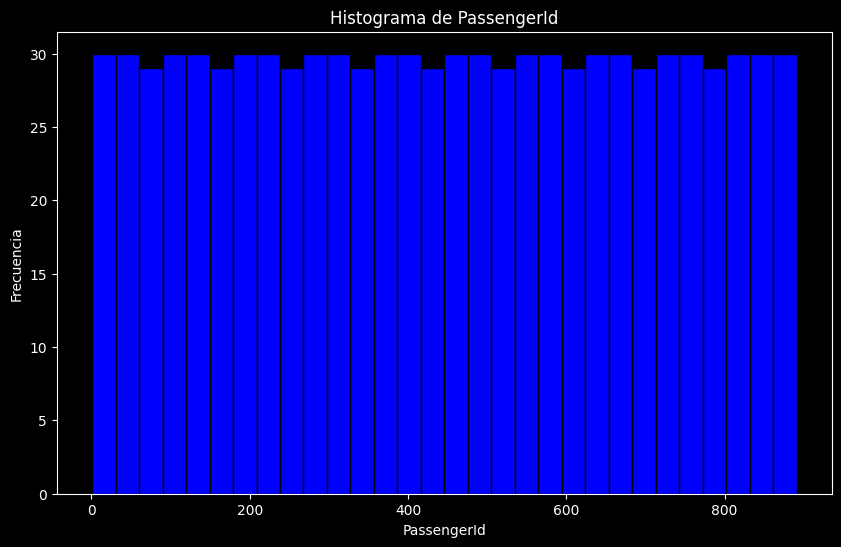

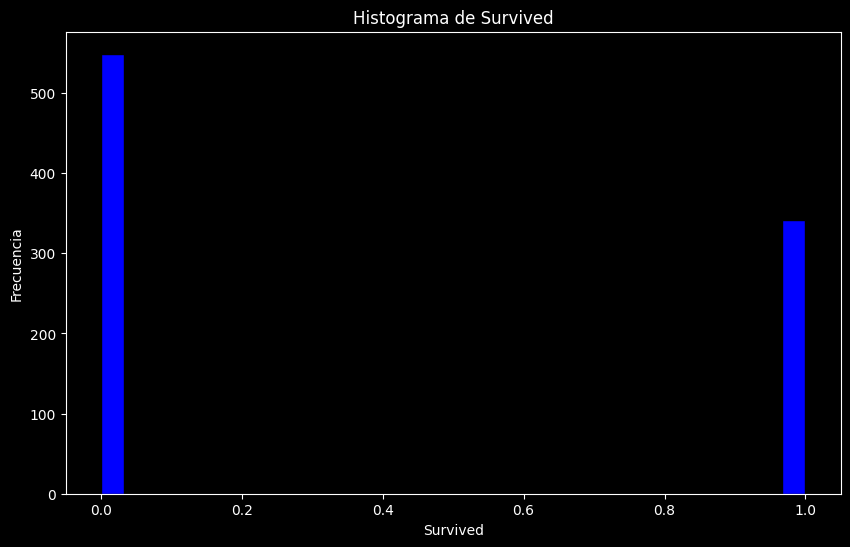

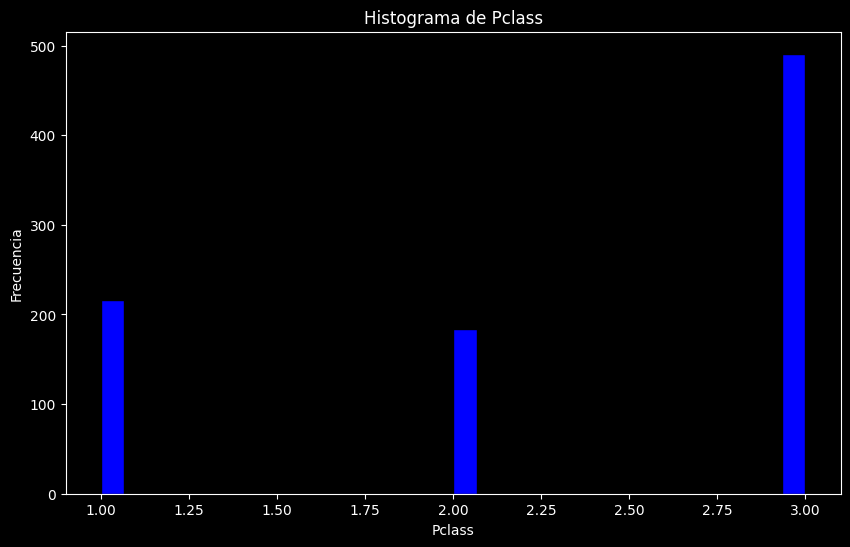

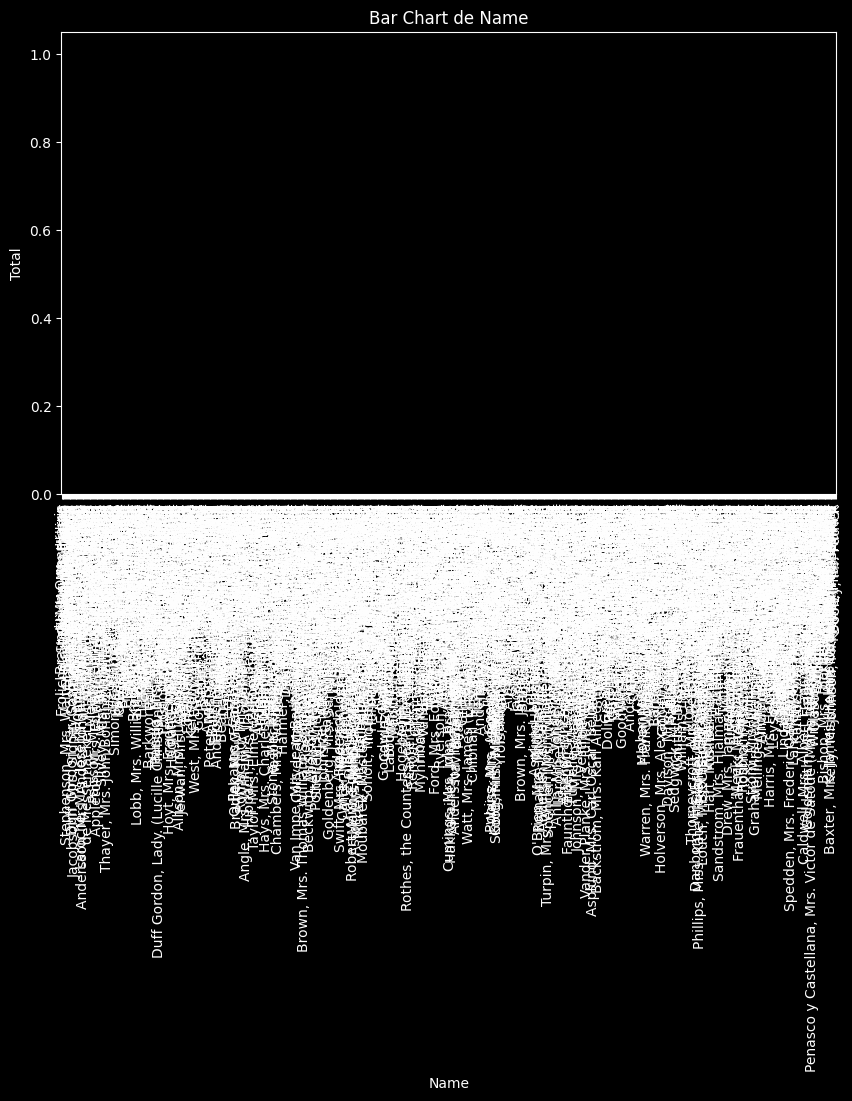

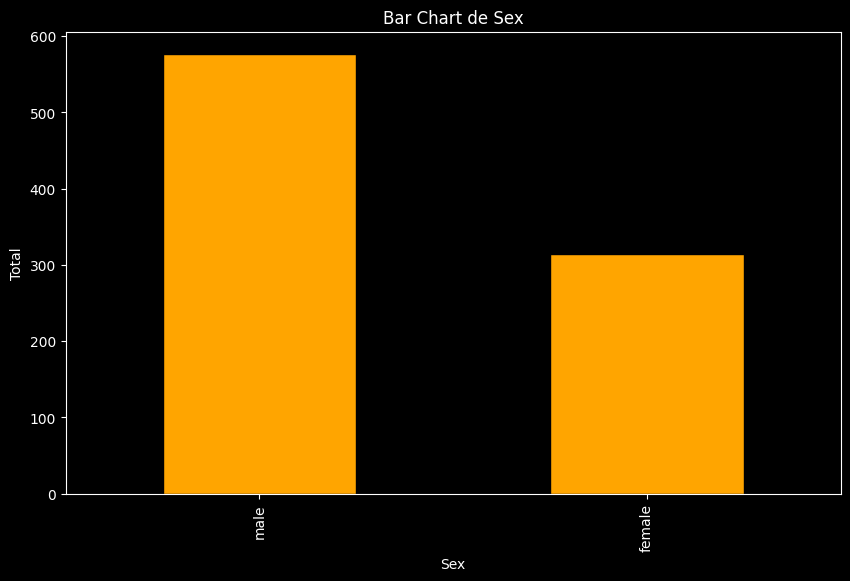

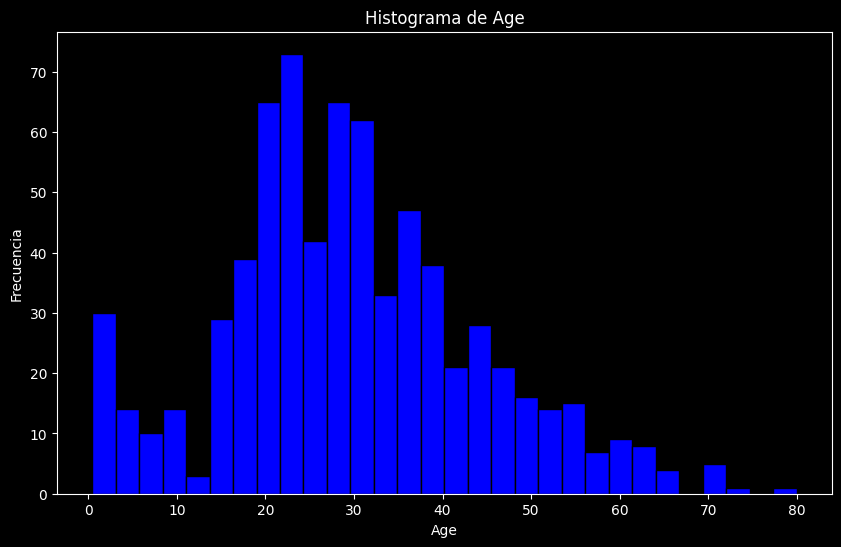

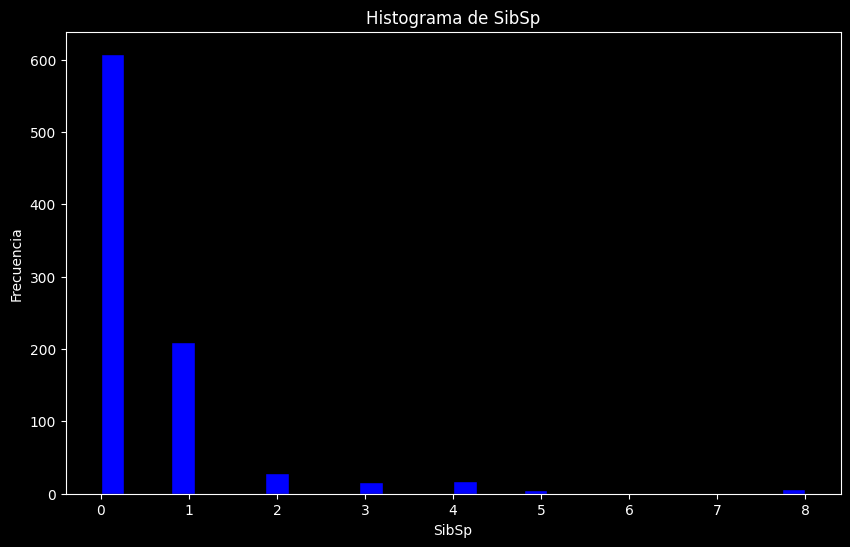

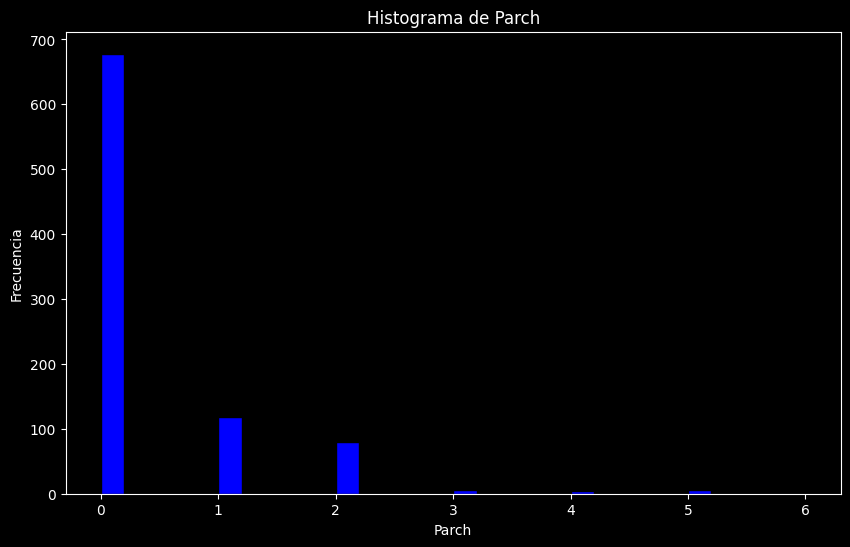

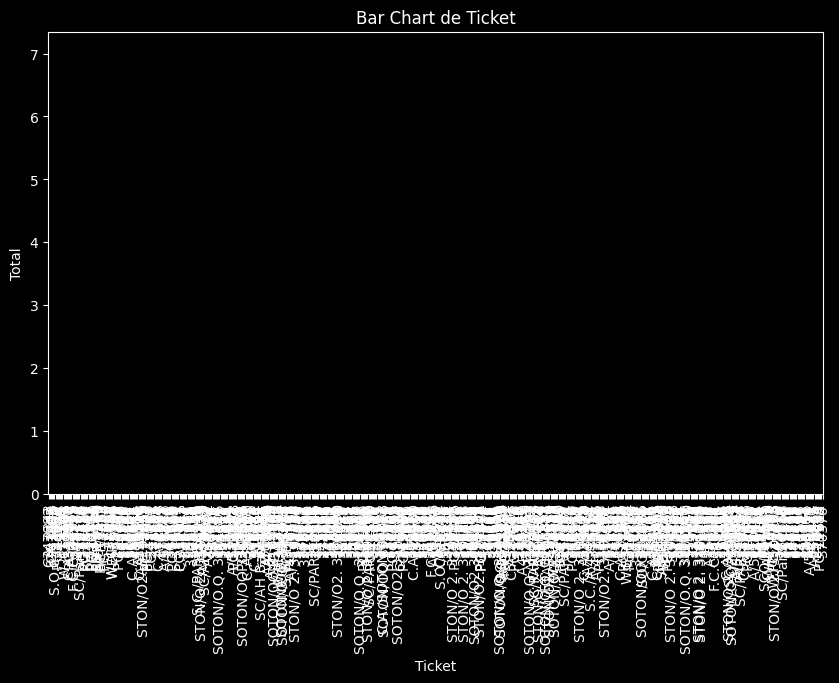

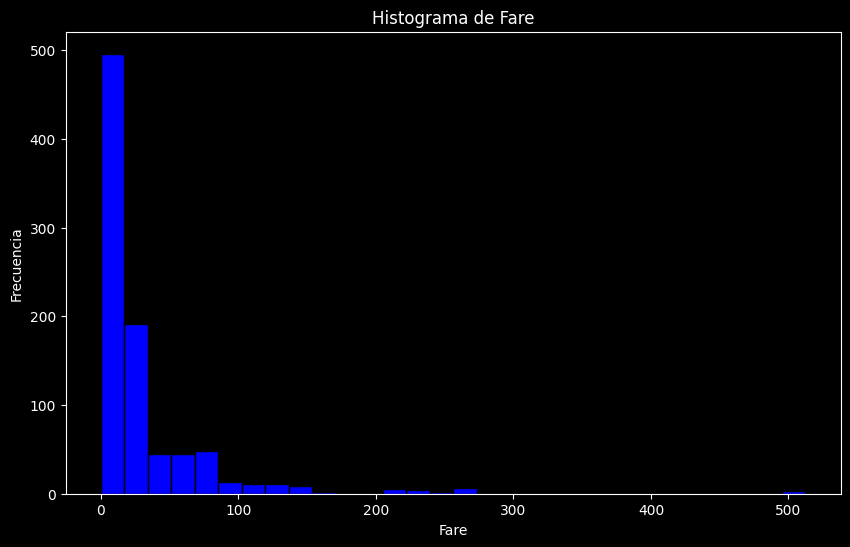

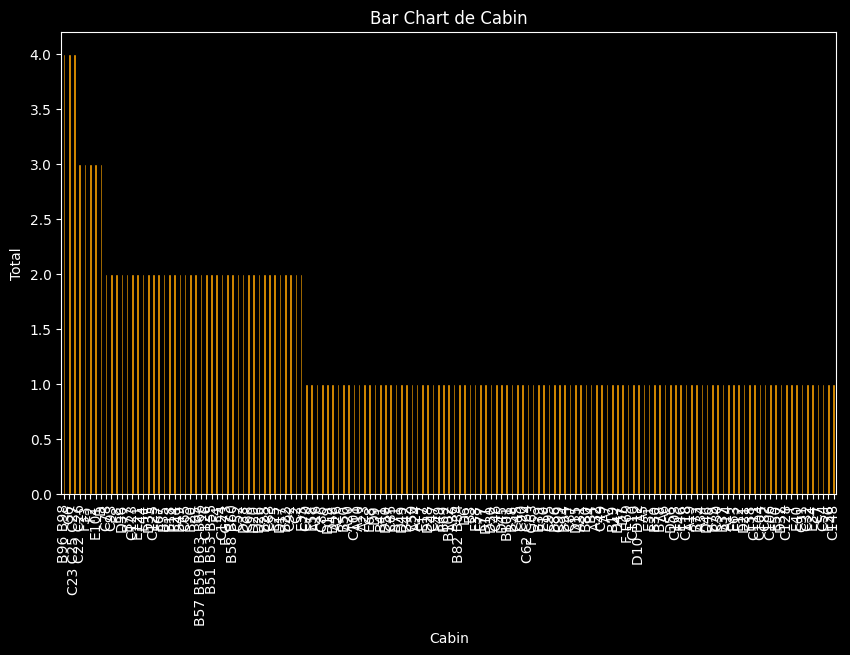

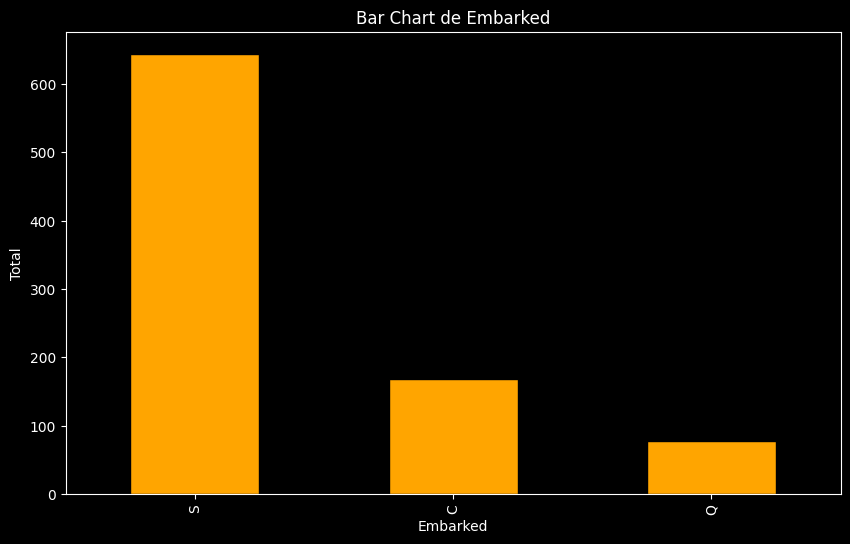

In [16]:
# Itrerar cada columna del DataFrame
for column in df.columns:
    plt.figure(figsize=(10, 6))
    # Comprobación de si la columna es numérica
    if pd.api.types.is_numeric_dtype(df[column]):
        plt.hist(df[column].dropna(), bins=30, color='blue', edgecolor='black')
        plt.title(f'Histograma de {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
    
    # Comprobación de si la columna es categórica
    elif isinstance(df[column].dtype, pd.CategoricalDtype) or df[column].dtype == 'object':
        df[column].value_counts().plot(kind='bar', color='orange', edgecolor='black')
        plt.title(f'Bar Chart de {column}')
        plt.xlabel(column)
        plt.ylabel('Total')
    
    plt.show()

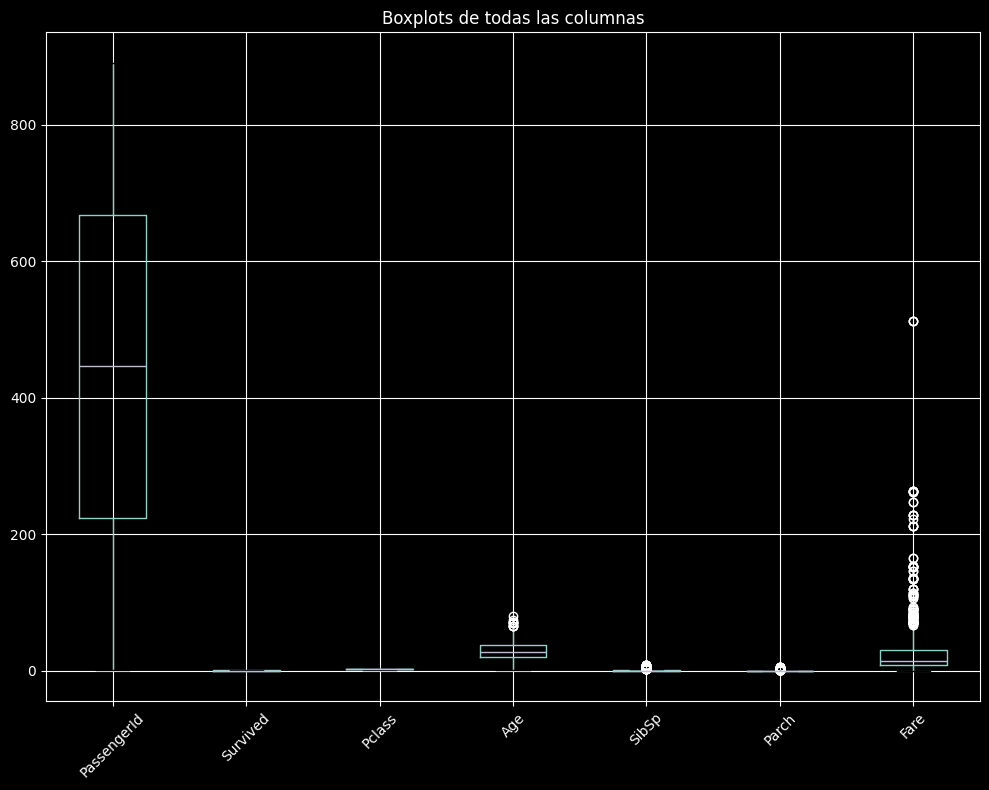

In [17]:
# Genera boxplots para cada columna numérica del DataFrame
df.boxplot(figsize=(10, 8), rot=45)
plt.title('Boxplots de todas las columnas')
plt.tight_layout()  # Para ajustar mejor el espacio de la gráfica
plt.show()

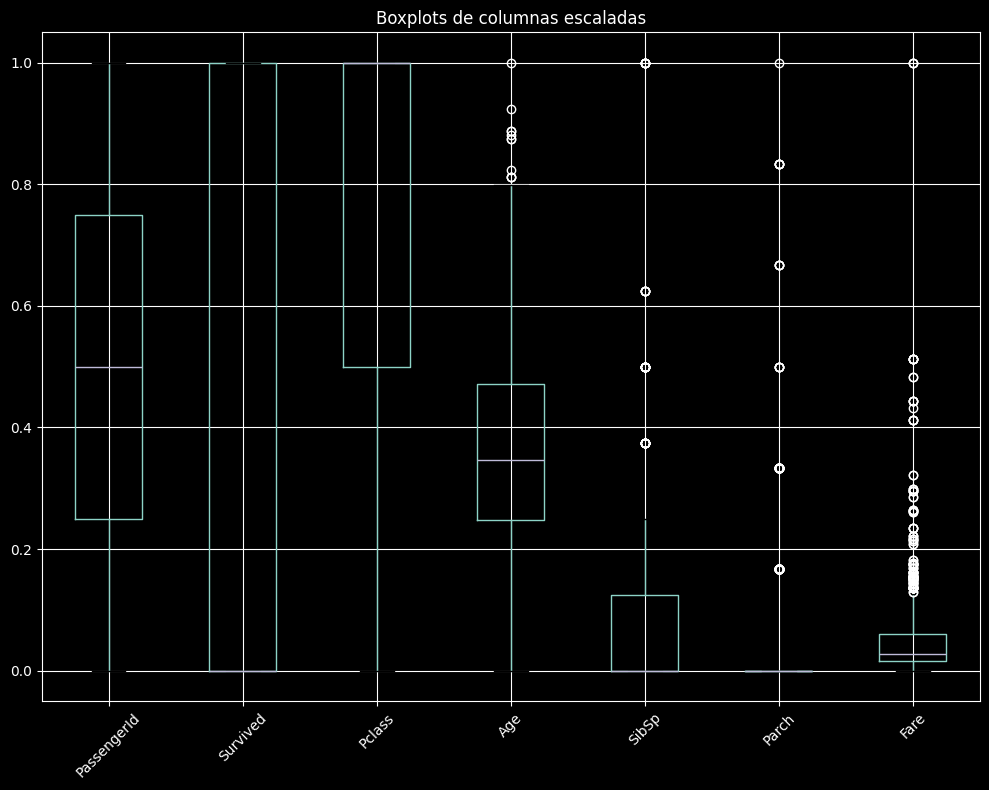

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionamos solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float', 'int']).columns
df_numeric = df[numeric_columns]

# Normalizamos los datos entre 0 y 1
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_columns)

# Genera boxplots para las columnas escaladas
df_scaled.boxplot(figsize=(10, 8), rot=45)
plt.title('Boxplots de columnas escaladas')
plt.tight_layout()
plt.show()

#### Comentarios:
Los valores parecen ser coherentes.

### Análisis Multivariable

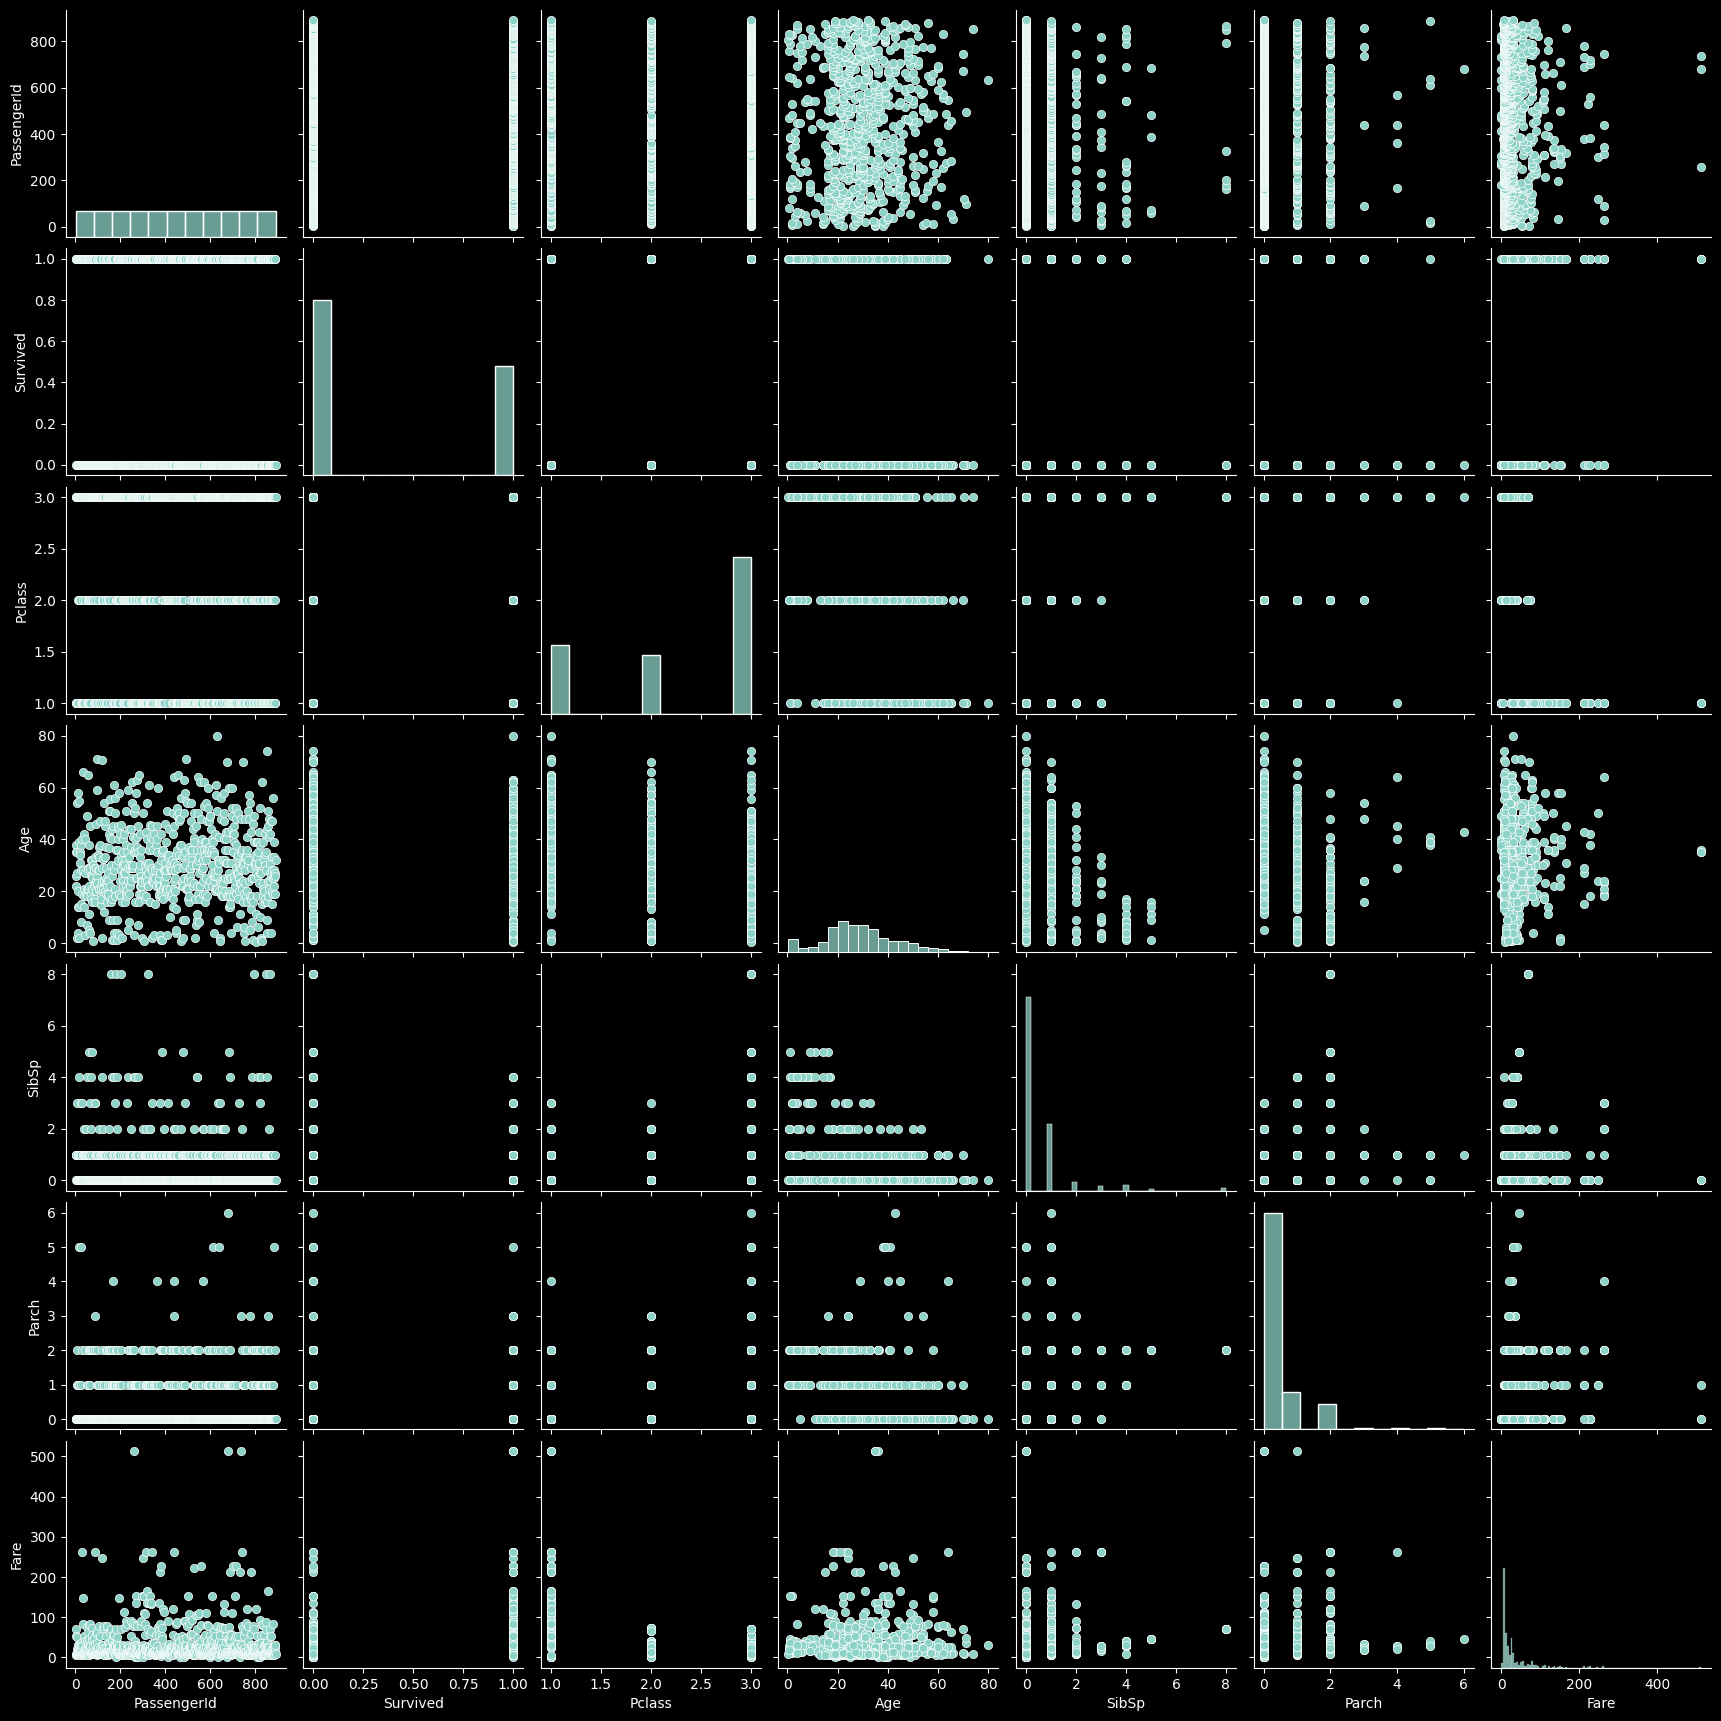

In [19]:
sns.pairplot(df);

In [20]:
# Correlaciones
df[num_columns].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [21]:
# Defino un cmap para ver más claramente los colores
cmap = sns.diverging_palette(500, 10, as_cmap=True)

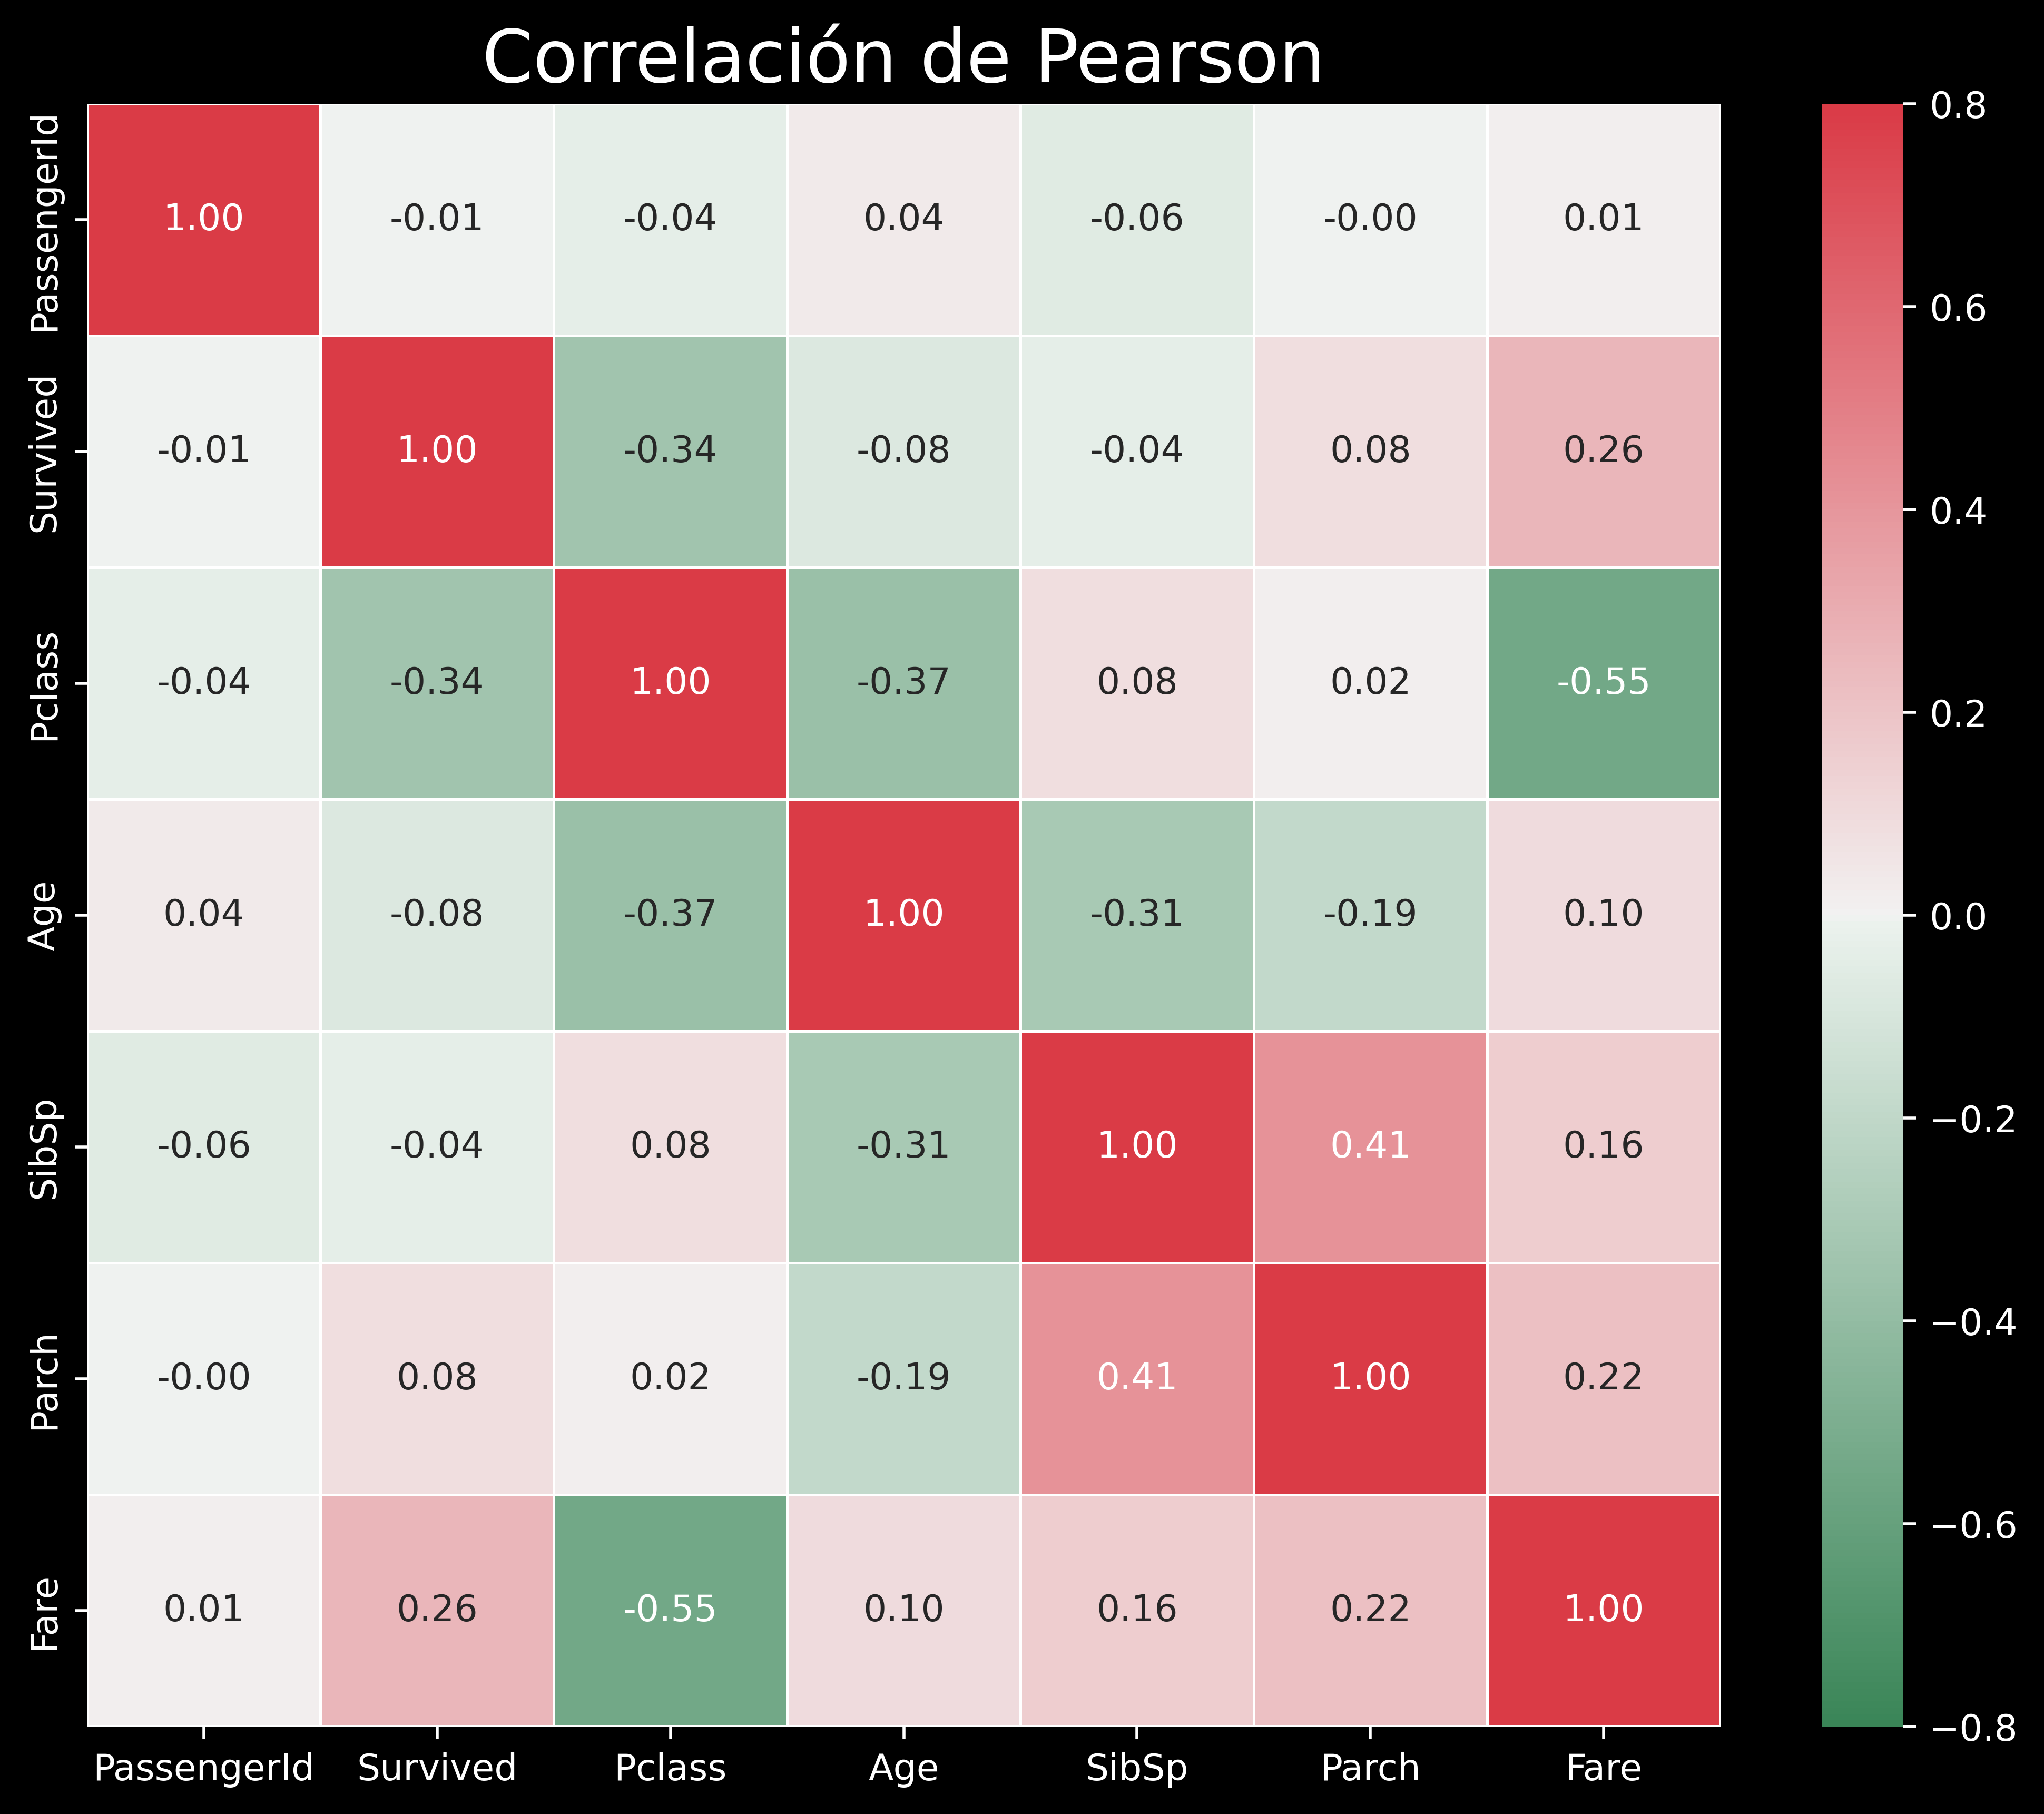

In [22]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(df[num_columns].corr(method='pearson'),
            annot=True, 
            fmt=".2f", linewidth=.5, cmap=cmap, vmin=-0.8, vmax=0.8)
plt.title("Correlación de Pearson", fontsize =20)
plt.show()

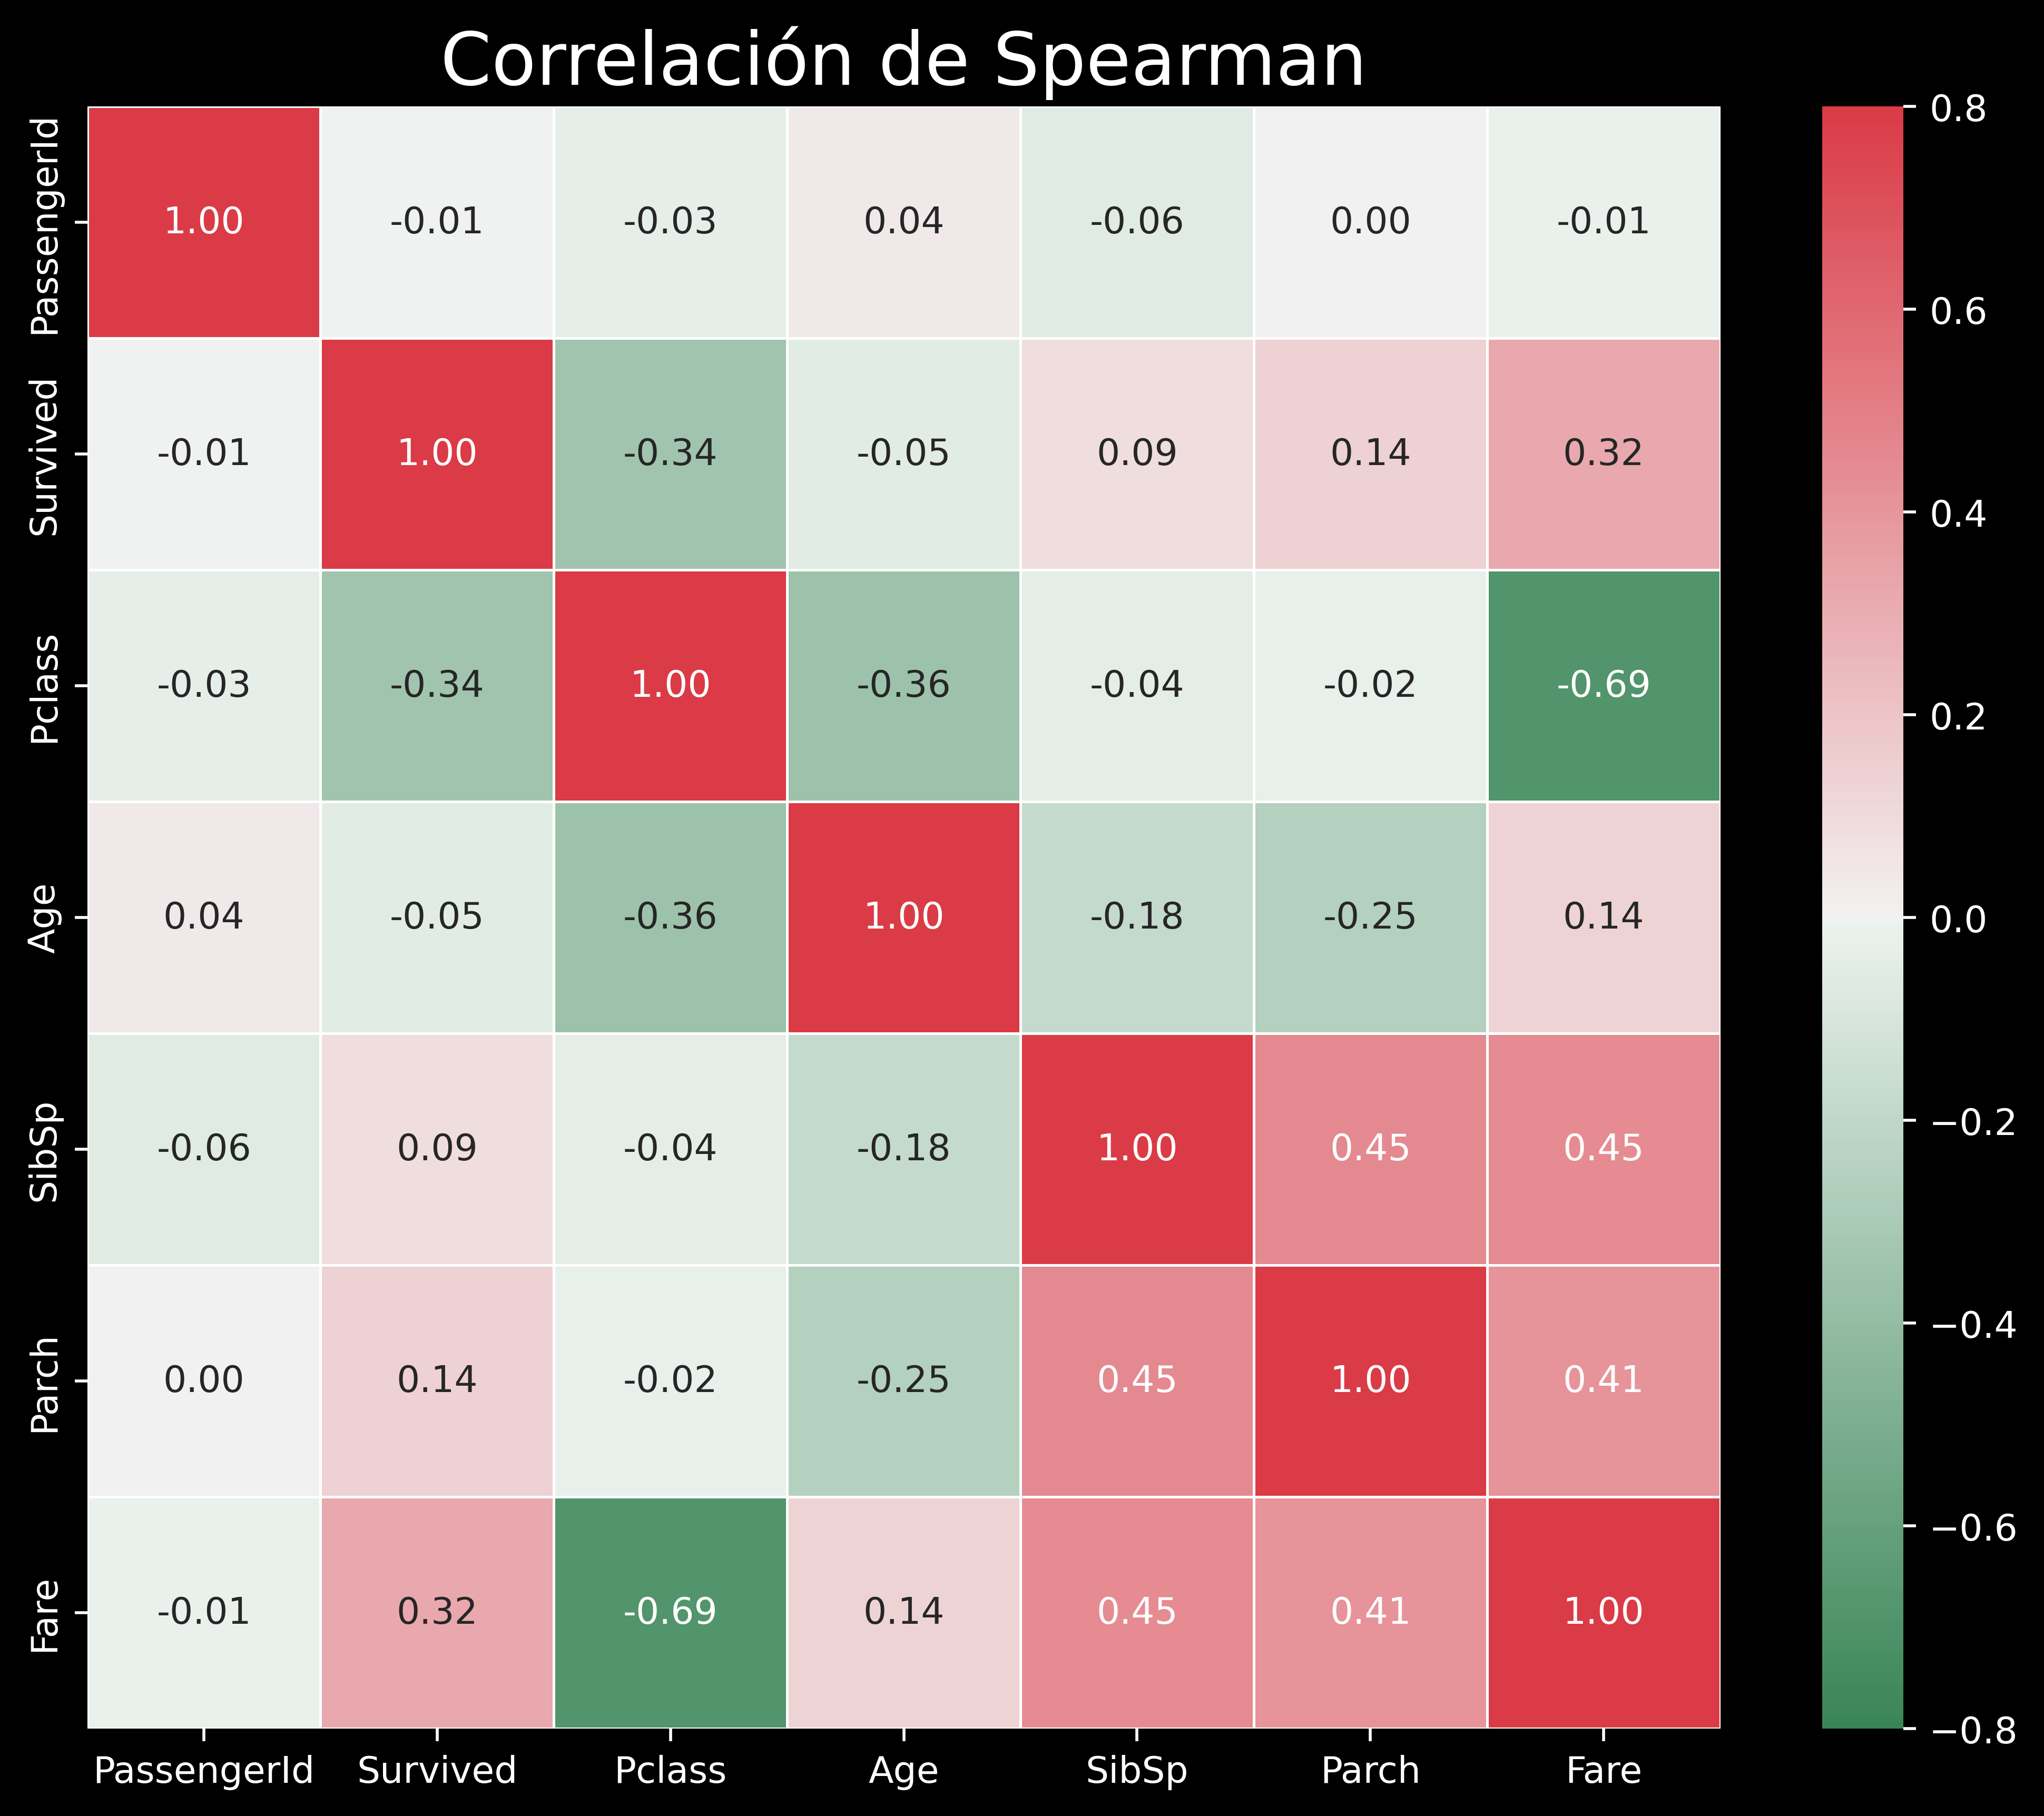

In [23]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(df[num_columns].corr(method='spearman'),
            annot=True, 
            fmt=".2f", linewidth=.5, cmap=cmap, vmin=-0.8, vmax=0.8)
plt.title("Correlación de Spearman", fontsize =20)
plt.show()

#### Comentarios:
No parece que haya correlaciones demasiado fuertes entre variables, salvo la trivial (clase-tarifa)

### Testeo Hipótesis

1. **Hipótesis de Género**: Las mujeres tuvieron una mayor probabilidad de sobrevivir que los hombres debido al protocolo de evacuación de "mujeres y niños primero".

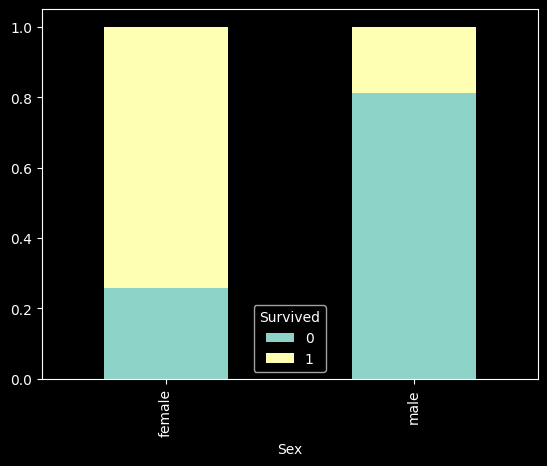

In [24]:
pd.crosstab(df['Sex'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

In [25]:
df.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Parece que gran parte de las mujeres consiguieron sobrevivir, al contrario que los hombres, por lo que la característica sexo será de relevancia para nuestro modelo.

2. **Hipótesis de Clase**: Los pasajeros de clases más altas (`Pclass = 1`) tuvieron una mayor probabilidad de sobrevivir en comparación con los pasajeros de clases más bajas, reflejando las desigualdades sociales de la época.

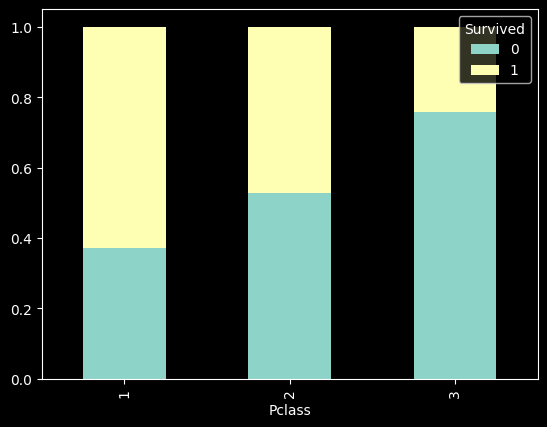

In [26]:
pd.crosstab(df['Pclass'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

In [27]:
df.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Los pasajeros de 1ª clase sobrevivieron en una proporción mucho mayor que el resto.

3. **Hipótesis de Edad**: Los pasajeros más jóvenes (niños) tuvieron una mayor probabilidad de sobrevivir debido a que se les dio prioridad en los esfuerzos de rescate.

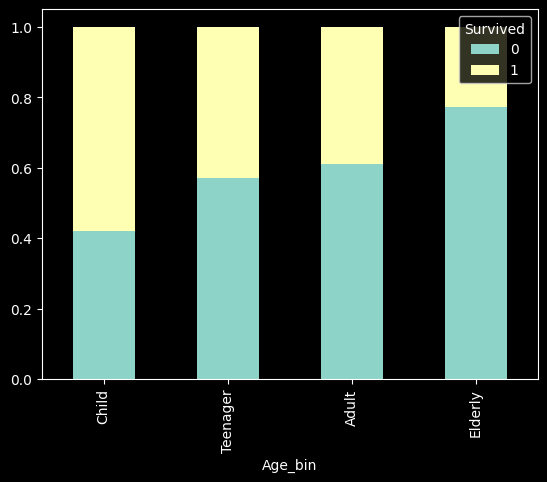

In [28]:
# Partimos las edades en grupos para poder plotear y calcular porcentajes
df['Age_bin'] = pd.cut(df['Age'], bins=[0, 12, 18, 60, 80], labels=['Child', 'Teenager', 'Adult', 'Elderly'])
pd.crosstab(df['Age_bin'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

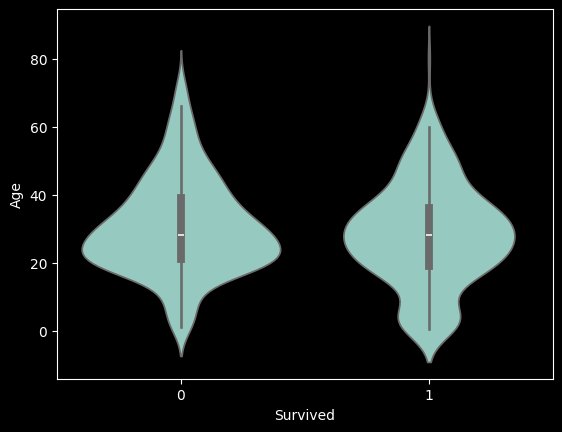

In [29]:
sns.violinplot(x='Survived', y='Age', data=df);

Parece relevante la edad de cara a si se sobrevive o no, puesto que según aumenta ésta, el porcentaje de supervivientes disminuye considerablemente.

4. **Hipótesis de Tamaño de la Familia**: Los pasajeros que viajaban con familia tuvieron mayores probabilidades de sobrevivir en comparación con aquellos que viajaban solos. Sin embargo, familias muy grandes pudieron tener dificultades para escapar juntas, reduciendo sus posibilidades de supervivencia.

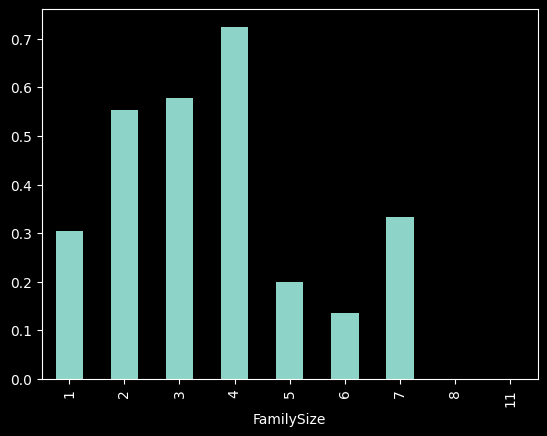

In [30]:
# Vemos el porcentaje de los que sobrevivieron sobre el total de cada grupo de familias
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.groupby('FamilySize')['Survived'].mean().plot(kind='bar');

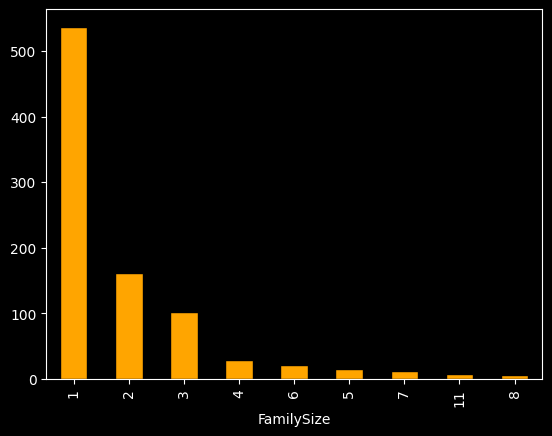

In [31]:
# Vemos la distribución de tamaños de familia
df["FamilySize"].value_counts().plot(kind='bar', color='orange', edgecolor='black');

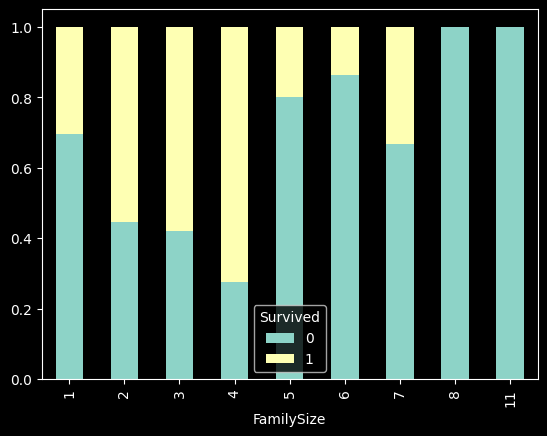

In [32]:
# Calculamos los porcentajes que representan los supervivientes en cada grupo de familias
pd.crosstab(df['FamilySize'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

Parece que sí crece el porcentaje de supervivientes al aproximarse a una familia próxima a 4, sin embargo, la mayoría de los viajeros estaban sólos, por lo que el dataset está altamente desbalanceado y si utilizamos este dato tendremos que manejarlo consecuentemente.

5. **Hipótesis de la Tarifa**: Los pasajeros que pagaron tarifas más altas tuvieron una mayor probabilidad de sobrevivir, ya que es probable que estuvieran en camarotes de clases superiores y tuvieran mejor acceso a los botes salvavidas.

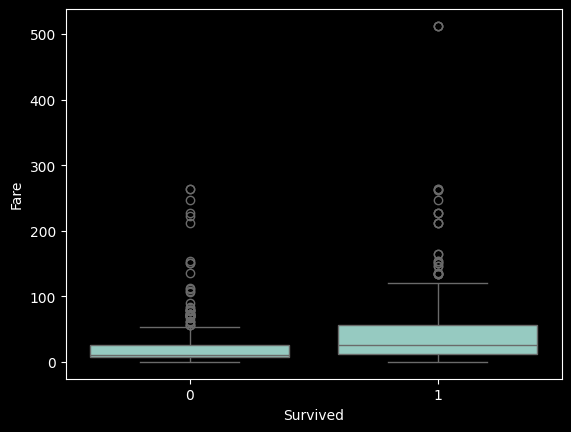

In [33]:
sns.boxplot(x='Survived', y='Fare', data=df);

In [34]:
df[['Fare', 'Survived']].corr(method='spearman')

,Fare,Survived
Fare,1.000000,0.323736
Survived,0.323736,1.000000


No parece haber suficiente correlación para confirmar la hipótesis, aunque testeamos convirtirendo la tarifa en 4 rangos para confirmar.

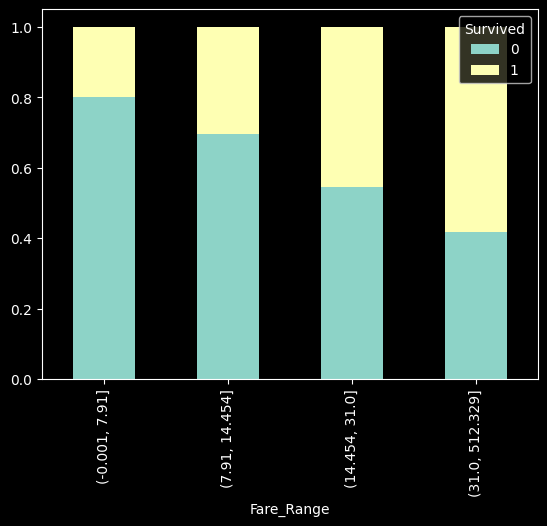

In [35]:
df['Fare_Range']=pd.qcut(df['Fare'],4)
pd.crosstab(df['Fare_Range'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

Al partir el precio pagado en 4 categorías sí que parece significante su impacto en el porcentaje de supervivientes, aunque hay que tener en mente de nuevo que el número de pasajeros con las tarifas más altas está desbalanceado.

6. **Hipótesis del Punto de Embarque**: Los pasajeros que embarcaron en ciertos puntos, como Cherburgo (`Embarked = C`), tuvieron mayores probabilidades de sobrevivir debido a diferencias en riqueza o ubicación de los camarotes.

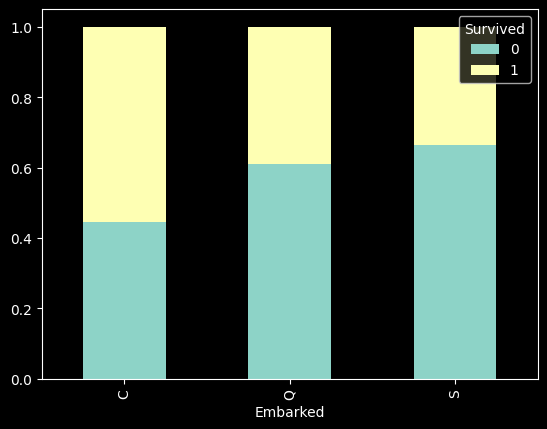

In [36]:
pd.crosstab(df['Embarked'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

In [37]:
df.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

No parece que el puerto de embarque sea una gran influencia de cara a la superviviencia, aunque puede merecer la pena estudiar su efecto en el modelo, puesto que sí que mejora notablemente para 'Cherburgo'.

7. **Hipótesis de Disponibilidad de Cabina**: Los pasajeros con información de cabina disponible (`Cabin` no nulo) tuvieron una mayor probabilidad de sobrevivir, ya que probablemente estaban en las secciones de clase alta del barco.

In [38]:
df['Has_Cabin'] = df['Cabin'].notnull().astype(int)
df.groupby('Has_Cabin')['Survived'].mean()

Has_Cabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64

Sí que parece relevante el hecho de que tenga cabina, puesto que duplica el porcentaje de supervivientes.

8. **Hipótesis de Título**: Los pasajeros con ciertos títulos, como `Mrs`, `Miss` o `Master` (niños), tuvieron mejores probabilidades de sobrevivir que otros, reflejando su estatus social o edad.

In [39]:
# Extracción del título de 'Name' mediante expresión regular, para lo que buscamos un espacio en blanco
# seguido de una secuencia de letras con la menos una mayúscula y que termine en punto
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

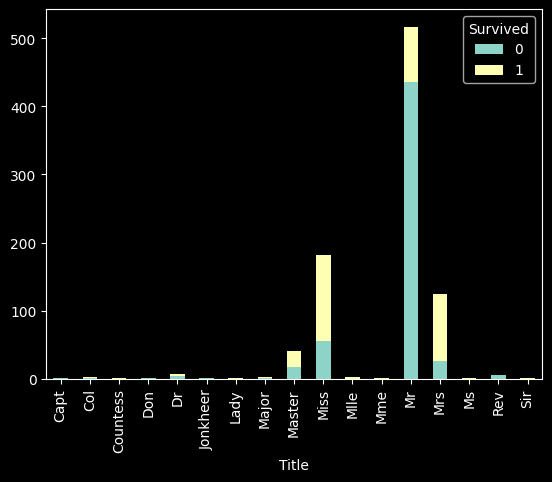

In [40]:
pd.crosstab(df['Title'], df['Survived']).plot(kind='bar', stacked=True);

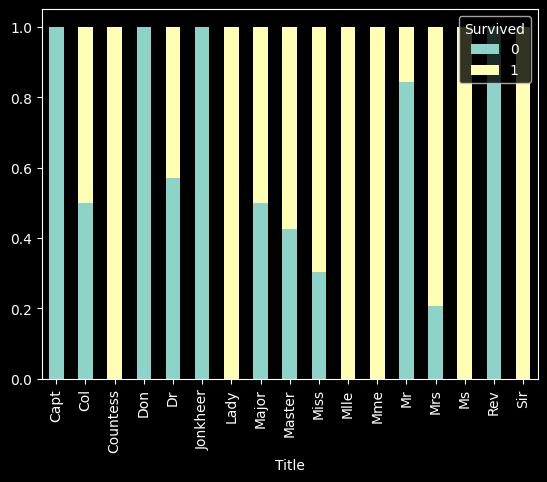

In [41]:
pd.crosstab(df['Title'], df['Survived'], normalize='index').plot(kind='bar', stacked=True);

In [42]:
df.groupby('Title')['Survived'].mean()

Title
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64

Gran parte de los títulos son Mr y Miss, el resto representan un porcentaje bajo sobre el total, por lo que no parece que tener en cuenta esta característica sea diferencial teniendo en cuenta que ya tenemos el sexo en el dataset.

9. **Hipótesis del Número de Ticket**: Los pasajeros con números de ticket similares, lo que podría indicar que viajaban juntos, tuvieron probabilidades de supervivencia correlacionadas.

In [43]:
# Definir la función para dividir el ticket en texto y número
def split_ticket(ticket):
    """
    Divide un string de ticket en dos partes: un texto y un número. 

    Si el string contiene un espacio, se asume que la primera parte es el texto y la segunda es el número.
    Si no contiene un espacio, se devuelve NaN para la parte de texto y se asume que todo el string es el número.

    Args:
        ticket (str): El string del ticket a dividir.

    Returns:
        tuple: Una tupla con la parte de texto (str o NaN) y la parte numérica (str).
    """
    parts = ticket.split(' ', 1)  # Dividir solo en el primer espacio
    if len(parts) == 1:  # Si solo hay una parte, es el número y la parte de texto es NaN
        return np.nan, parts[0]
    else:  # De lo contrario, devolver la parte de texto y número
        return parts[0], parts[1]

# Aplicar la función para crear dos nuevas columnas
df[['Ticket_Text', 'Ticket_Number']] = df['Ticket'].apply(split_ticket).apply(pd.Series)

# Convertir la columna 'Ticket_Number' a valores numéricos donde sea posible
df['Ticket_Number'] = pd.to_numeric(df['Ticket_Number'], errors='coerce')

# Mostrar el resultado para verificar la solución
print(df[['Ticket', 'Ticket_Text', 'Ticket_Number']])

               Ticket Ticket_Text  Ticket_Number
0           A/5 21171         A/5        21171.0
1            PC 17599          PC        17599.0
2    STON/O2. 3101282    STON/O2.      3101282.0
3              113803         NaN       113803.0
4              373450         NaN       373450.0
..                ...         ...            ...
886            211536         NaN       211536.0
887            112053         NaN       112053.0
888        W./C. 6607       W./C.         6607.0
889            111369         NaN       111369.0
890            370376         NaN       370376.0

[891 rows x 3 columns]


Vemos que no existe correlación entre el número de ticket y la supervivencia, por lo que investigaremos sobre los que comparten mismo ticket.

In [44]:
# Agrupa por número de tickets y cuenta los pasajeros y supervivientes
ticket_group = df.groupby('Ticket_Number')['Survived'].agg(['count', 'sum'])

# 'count' muestra cuántos pasajeros comparten el mismo ticket
# 'sum' muestra cuántos de esos pasajeros sobrevivieron
ticket_group.rename(columns={'count': 'Passengers_on_ticket', 'sum': 'Survivors_on_ticket'}, inplace=True)

# Calcula el porcentaje de supervivientes sobre el total de pasajeros en el ticket
ticket_group['Survivors_percent'] = ticket_group['Survivors_on_ticket'] / ticket_group['Passengers_on_ticket']

# Mostrar el resultado para ver cuántos pasajeros compartieron tickets y cuántos sobrevivieron
ticket_group.head()

,Passengers_on_ticket,Survivors_on_ticket,Survivors_percent
Ticket_Number,,,
3.0,2,0,0.0
693.0,1,0,0.0
695.0,1,0,0.0
751.0,2,1,0.5
752.0,1,1,1.0


In [45]:
# Filtramos los tickets con sólo un pasajero (no es lo que buscamos en esta hipótesis)
ticket_group = ticket_group[ticket_group["Passengers_on_ticket"] > 1]

In [46]:
# Añadir una nueva columna para verificar si todos los pasajeros con el mismo ticket sobrevivieron o no
ticket_group['All_survived'] = (ticket_group['Survivors_on_ticket'] == ticket_group['Passengers_on_ticket']).astype(int)
ticket_group['None_survived'] = (ticket_group['Survivors_on_ticket'] == 0).astype(int)

# Proporción de tickets donde todos los pasajeros sobrevivieron o ninguno sobrevivió
all_survived_rate = ticket_group['All_survived'].mean()
none_survived_rate = ticket_group['None_survived'].mean()

print(f"Proporción de tickets donde todos los pasajeros sobrevivieron: {all_survived_rate:.2%}")
print(f"Proporción de tickets donde ninguno de los pasajeros sobrevivió: {none_survived_rate:.2%}")

Proporción de tickets donde todos los pasajeros sobrevivieron: 35.82%
Proporción de tickets donde ninguno de los pasajeros sobrevivió: 27.61%


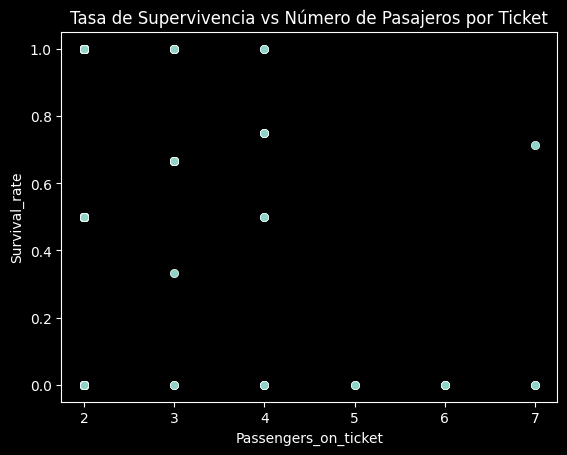

In [47]:
# Añadir una tasa de supervivencia por ticket
ticket_group['Survival_rate'] = ticket_group['Survivors_on_ticket'] / ticket_group['Passengers_on_ticket']

# Graficar la relación entre el número de pasajeros por ticket y la tasa de supervivencia
sns.scatterplot(x='Passengers_on_ticket', y='Survival_rate', data=ticket_group)
plt.title('Tasa de Supervivencia vs Número de Pasajeros por Ticket')
plt.show()

In [48]:
# Correlación entre el número de pasajeros por ticket y la tasa de supervivencia
correlation = ticket_group[['Passengers_on_ticket', 'Survival_rate']].corr(method='spearman').iloc[0, 1]
print(f"Correlación entre el número de pasajeros por ticket y la tasa de supervivencia: {correlation:.2f}")

Correlación entre el número de pasajeros por ticket y la tasa de supervivencia: -0.07


No parece que haya una correlación entre el número de ticket y la probabilidad de sobrevivir.

10. **Hipótesis de Interacciones**:
    - **Género y Clase**: Las mujeres de clases más altas tuvieron la mayor tasa de supervivencia.
    - **Edad y Clase**: Los niños de clases más bajas tuvieron menos probabilidades de sobrevivir que los niños de clases más altas.
    - **Tamaño de Familia y Tarifa**: Los pasajeros con familias más pequeñas y tarifas más altas tuvieron mayores probabilidades de supervivencia.

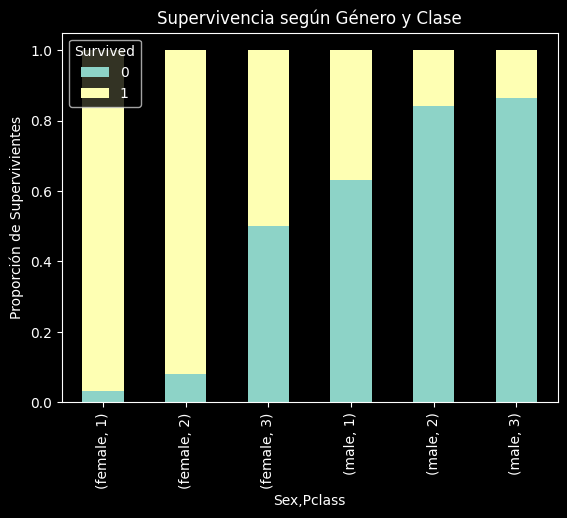

Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64

In [49]:
# Crear una tabla cruzada entre género, clase y supervivencia
pd.crosstab([df['Sex'], df['Pclass']], df['Survived'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Supervivencia según Género y Clase')
plt.ylabel('Proporción de Supervivientes')
plt.show()

# Analizar la tasa de supervivencia por género y clase
df.groupby(['Sex', 'Pclass'])['Survived'].mean()

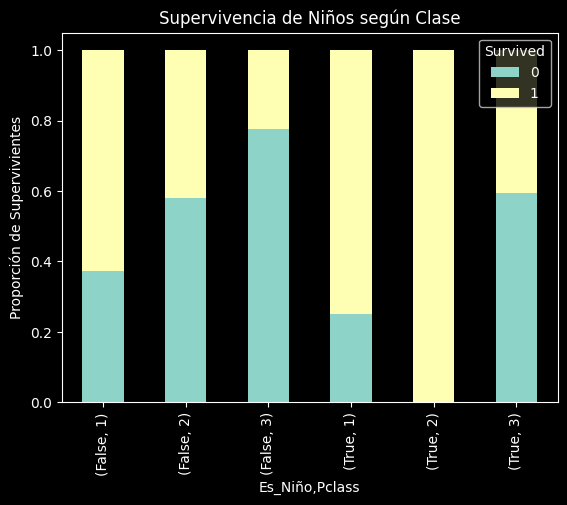

Es_Niño  Pclass
False    1         0.627358
         2         0.419162
         3         0.225225
True     1         0.750000
         2         1.000000
         3         0.404255
Name: Survived, dtype: float64

In [50]:
# Definir una columna 'Es_Niño' para los menores de 12 años
df['Es_Niño'] = df['Age'] < 12

# Crear una tabla cruzada entre clase, si es niño, y supervivencia
pd.crosstab([df['Es_Niño'], df['Pclass']], df['Survived'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Supervivencia de Niños según Clase')
plt.ylabel('Proporción de Supervivientes')
plt.show()

# Analizar la tasa de supervivencia por si es niño y la clase
df.groupby(['Es_Niño', 'Pclass'])['Survived'].mean()

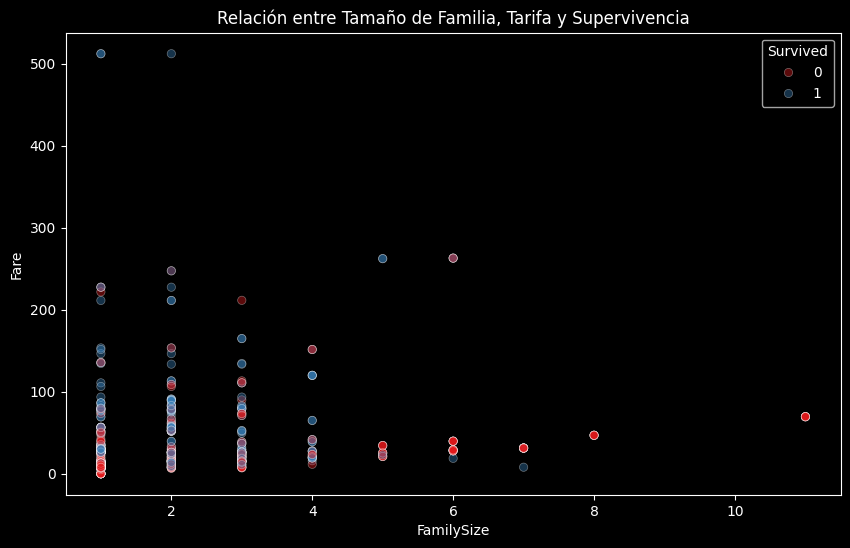

FamilySize  Rango_Tarifa   
1           (-0.001, 7.91]     0.200000
            (7.91, 14.454]     0.278075
            (14.454, 31.0]     0.407895
            (31.0, 512.329]    0.593750
2           (-0.001, 7.91]     0.222222
            (7.91, 14.454]     0.458333
            (14.454, 31.0]     0.421053
            (31.0, 512.329]    0.732394
3           (-0.001, 7.91]     0.000000
            (7.91, 14.454]     0.363636
            (14.454, 31.0]     0.629630
            (31.0, 512.329]    0.636364
4           (7.91, 14.454]     0.000000
            (14.454, 31.0]     0.714286
            (31.0, 512.329]    0.785714
5           (14.454, 31.0]     0.111111
            (31.0, 512.329]    0.333333
6           (14.454, 31.0]     0.083333
            (31.0, 512.329]    0.200000
7           (7.91, 14.454]     1.000000
            (31.0, 512.329]    0.272727
8           (31.0, 512.329]    0.000000
11          (31.0, 512.329]    0.000000
Name: Survived, dtype: float64

In [51]:
# Crear un gráfico que relacione la tarifa, el tamaño de la familia y la supervivencia
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FamilySize', y='Fare', hue='Survived', data=df, palette='Set1', alpha=0.4)
plt.title('Relación entre Tamaño de Familia, Tarifa y Supervivencia')
plt.show()

# Analizar la tasa de supervivencia según el tamaño de la familia y el rango de tarifa
df['Rango_Tarifa'] = pd.qcut(df['Fare'], 4)  # Dividir la tarifa en cuartiles
df.groupby(['FamilySize', 'Rango_Tarifa'], observed=True)['Survived'].mean()

##### Testearemos las hipótesis de forma estadística:

- [chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html): se utiliza para realizar la prueba de independencia de Chi-cuadrado en una tabla de contingencia. Esta prueba evalúa si existe una relación significativa entre variables categóricas, es decir, si las variables son independientes o no. Interpretación de resultados:
    - Estadístico Chi-cuadrado (chi2_stat): Cuantifica la diferencia entre las frecuencias observadas y las esperadas. Un valor más alto indica que las diferencias son grandes, lo que podría sugerir una relación significativa entre las variables.
    - Valor p (p_val): Es el valor que te indica si la relación es estadísticamente significativa. Si el valor p es menor a un nivel de significancia comúnmente usado (por ejemplo, 0.05), entonces se rechaza la hipótesis nula de que las variables son independientes.
        - Si p_val < 0.05: Las variables no son independientes, lo que sugiere una relación significativa entre ellas.
        - Si p_val ≥ 0.05: No hay suficiente evidencia para rechazar la hipótesis nula, por lo que no hay una relación significativa entre las variables.
    - Grados de libertad (dof): Es el número de categorías independientes que están siendo comparadas. Se calcula como: $dof = (num\_filas - 1) \cdot (num\_cols - 1)$
    - Valores esperados (expected): Esta es la tabla que contiene las frecuencias esperadas si las dos variables fueran completamente independientes. Se calculan en función de las proporciones marginales de la tabla original.

In [52]:
# Tabla de contingencia para clase y género con la variable objetivo 'Survived'
contingencia = pd.crosstab([df['Sex'], df['Pclass']], df['Survived'])

# Aplicar la prueba Chi-cuadrado
chi2_stat, p_val, dof, ex = chi2_contingency(contingencia)

print(f"Statistic: {chi2_stat}\n", 
      f"P-value: {p_val}\n",
      f"Degrees of freedom: {dof}\n",
      f"Expected frequency: {ex}")

Statistic: 350.67530839575556
 P-value: 1.2523073473573164e-73
 Degrees of freedom: 5
 Expected frequency: [[ 57.91919192  36.08080808]
 [ 46.82828283  29.17171717]
 [ 88.72727273  55.27272727]
 [ 75.17171717  46.82828283]
 [ 66.54545455  41.45454545]
 [213.80808081 133.19191919]]


Un valor tan alto en el estadístico nos indica posible fuerte relación entre las dos variables, que se confirma con el tan pequeño valor de p-value, por lo que rechazamos la hipótesis nula (que las dos variables no son independientes), resultando en una relación estadística significativa entre éstas.

In [53]:
# Tabla de contingencia para 'Es_Niño' y 'Pclass' con la variable objetivo 'Survived'
contingencia = pd.crosstab([df['Es_Niño'], df['Pclass']], df['Survived'])

# Aplicar la prueba Chi-cuadrado
chi2_stat, p_val, dof, ex = chi2_contingency(contingencia)

print(f"Statistic: {chi2_stat}\n", 
      f"P-value: {p_val}\n",
      f"Degrees of freedom: {dof}\n",
      f"Expected frequency: {ex}")

Statistic: 130.90822316646413
 P-value: 1.526946436191978e-26
 Degrees of freedom: 5
 Expected frequency: [[130.62626263  81.37373737]
 [102.8989899   64.1010101 ]
 [273.57575758 170.42424242]
 [  2.46464646   1.53535354]
 [ 10.47474747   6.52525253]
 [ 28.95959596  18.04040404]]


Un valor tan alto en el estadístico nos indica posible fuerte relación entre las dos variables, que se confirma con el tan pequeño valor de p-value, por lo que rechazamos la hipótesis nula (que las dos variables no son independientes), resultando en una relación estadística significativa entre éstas.

## Conclusiones

##### Preprocesado:
- Existen missing values en 'Age', 'Cabin' y 'Embarked' con los que tendremos que tratar.
- Los tipos de las variables parecen correctos, aunque 'Age' debería ser entero y aparece como float --> posiblemente por los NaNs. Al imputar podemos transformarlo.
- La columna 'Name' no aporta mucho por sí misma,  y tras analizar lo que podemos extraer no parece aportar valor.

##### Variables relevantes:
- Sex
- Pclass
- Age -> transformar en bins por grupos parece que puede ser buena opción (`df['Age_bin'] = pd.cut(df['Age'], bins=[0, 12, 18, 60, 80], labels=['Child', 'Teenager', 'Adult', 'Elderly'])`).
- `FamilySize = (SibSp + Parch + 1)` -> puede ser interesante, pero está altamente desbalanceado hacia los pasajeros que viajan sólos.
- Embarked
- `Has_Cabin = df['Cabin'].notnull().astype(int)` -> parece relevante que el pasajero tenga cabina.
- Fare -> transformar en Fare_Range (`df['Fare_Range']=pd.qcut(df['Fare'],4)`)